In [89]:
import re
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [90]:
# Function to load and parse multiple JSON objects from a file
def load_json(file_path):
    data = []
    with open(file_path, 'r') as file:
        content = file.read()
        for line in content.splitlines():
            if line.strip():  # Ignore empty lines
                try:
                    data.append(json.loads(line))
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON: {e}")
    return data

In [91]:
irony_data = load_json('irony_metapro.json')
sarcasm_data = load_json('sarcasm_metapro.json')
satire_data = load_json('satire_metapro.json')

In [92]:
# Function to parse metapro_output
def parse_metapro_output(output):
    pattern = r'PoS\[(?P<PoS>.+?)\]Target\[(?P<Target>.+?)\|(?P<Target_Concept>.+?)\]Source\[(?P<Source>.+?)\|(?P<Source_Concept>.+?)\]'
    matches = re.finditer(pattern, output)
    parsed = []
    for match in matches:
        parsed.append({
            'PoS': match.group('PoS'),
            'Source': match.group('Source'),
            'Source_Concept': match.group('Source_Concept'),
            'Target': match.group('Target'),
            'Target_Concept': match.group('Target_Concept'),
            'Mapping': f"{match.group('Target_Concept')} - {match.group('Source_Concept')}"
            # 'Mapping': f"{match.group('Source_Concept')} - {match.group('Target_Concept')}"
        })
    return parsed

In [93]:
# Function to parse data from JSON
def parse_data(data):
    parsed = []
    for item in data:
        for key, value in item.items():
            metapro_output = value.get('metapro_output', '')
            parsed.extend(parse_metapro_output(metapro_output))
    return pd.DataFrame(parsed)

In [94]:
df_irony = parse_data(irony_data)
df_sarcasm = parse_data(sarcasm_data)
df_satire = parse_data(satire_data)

In [95]:
# Shorten longer concept mappings (example: BCP, LIQ, HCP)
replace_dict = {
    'BASIC_COGNITIVE_PROCESS': 'BCP',
    'LARGE_INDEFINITE_QUANTITY': 'LIQ',
    'HIGHER_COGNITIVE_PROCESS': 'HCP'
}

df_irony.replace(replace_dict, inplace=True)
df_sarcasm.replace(replace_dict, inplace=True)
df_satire.replace(replace_dict, inplace=True)

# Ensure the replacements are applied to the 'Mapping' column
df_irony['Mapping'] = df_irony['Mapping'].replace(replace_dict, regex=True)
df_sarcasm['Mapping'] = df_sarcasm['Mapping'].replace(replace_dict, regex=True)
df_satire['Mapping'] = df_satire['Mapping'].replace(replace_dict, regex=True)

In [96]:
# Concatenate all dataframes
df_all = pd.concat([df_irony.assign(Type='Irony'), df_sarcasm.assign(Type='Sarcasm'), df_satire.assign(Type='Satire')])
df_all.head()

,PoS,Source,Source_Concept,Target,Target_Concept,Mapping,Type
0,VBG,play,ACTION,use,UTILITY,UTILITY - ACTION,Irony
1,NN,card,LIST,board,DEVICE,DEVICE - LIST,Irony
2,NN,move,DECISION,turn,CHANGE_OF_DIRECTION,CHANGE_OF_DIRECTION - DECISION,Irony
3,JJ,next,POSITION,following,MULTITUDE,MULTITUDE - POSITION,Irony
4,VBG,step,ACTION,move,ACT,ACT - ACTION,Irony


### Basic Statistical Analysis

In [98]:
# Function for unique count analysis
def unique_count_analysis(df, name):
    unique_pos = df['PoS'].nunique()
    unique_source = df['Source'].nunique()
    unique_target = df['Target'].nunique()
    unique_mappings = df['Mapping'].nunique()
    total_metaphorical_sequences = len(df)

    print(f"Unique Count Analysis for {name}:")
    print(f"Unique POS: {unique_pos}")
    print(f"Unique Source Concepts: {unique_source}")
    print(f"Unique Target Concepts: {unique_target}")
    print(f"Unique Mappings: {unique_mappings}")
    print(f"Total Metaphorical Sequences: {total_metaphorical_sequences}")
    print()


In [99]:
# Analysis for individual types
unique_count_analysis(df_irony, 'Irony')
unique_count_analysis(df_sarcasm, 'Sarcasm')
unique_count_analysis(df_satire, 'Satire')

# Combined analysis
unique_count_analysis(df_all, 'Combined')

Unique Count Analysis for Irony:
Unique POS: 12
Unique Source Concepts: 2264
Unique Target Concepts: 2146
Unique Mappings: 4216
Total Metaphorical Sequences: 13363

Unique Count Analysis for Sarcasm:
Unique POS: 12
Unique Source Concepts: 2029
Unique Target Concepts: 1963
Unique Mappings: 3844
Total Metaphorical Sequences: 13083

Unique Count Analysis for Satire:
Unique POS: 12
Unique Source Concepts: 2106
Unique Target Concepts: 1948
Unique Mappings: 3814
Total Metaphorical Sequences: 10689

Unique Count Analysis for Combined:
Unique POS: 12
Unique Source Concepts: 3676
Unique Target Concepts: 3151
Unique Mappings: 7529
Total Metaphorical Sequences: 37135



### Common Mapping Analysis

In [100]:
# Prepare data for heatmap
def prepare_heatmap_data(df, top_n=30):
    concept_mapping_counts = df.groupby(['Source_Concept', 'Target_Concept']).size().reset_index(name='Counts')
    top_mappings = concept_mapping_counts.nlargest(top_n, 'Counts')
    heatmap_data = top_mappings.pivot(index='Source_Concept', columns='Target_Concept', values='Counts')
    return heatmap_data

In [101]:
heatmap_data_irony = prepare_heatmap_data(df_irony)
heatmap_data_sarcasm = prepare_heatmap_data(df_sarcasm)
heatmap_data_satire = prepare_heatmap_data(df_satire)

In [102]:
heatmap_data_irony.head()

Target_Concept,ACKNOWLEDGMENT,ACT,ACTION,ACTIVITY,BCP,COLLECTION,CONCERN,CONSISTENCY,DIRECTION,DISAPPEARANCE,EVENT,HCP,IMPORTANCE,MOTION,PERCEPTION,PORTRAYAL,POSSESSION,PRODUCTION,PROPERTY,SIZE
Source_Concept,,,,,,,,,,,,,,,,,,,,
ACT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,NaN,NaN,136.0,NaN,50.0,NaN
ACTION,NaN,140.0,NaN,80.0,NaN,NaN,NaN,NaN,NaN,49.0,NaN,NaN,NaN,NaN,NaN,52.0,76.0,53.0,NaN,NaN
ACTIVITY,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BCP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.0,NaN,NaN,73.0,40.0,NaN,NaN,NaN,NaN
COMMUNICATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,NaN,NaN,NaN


In [145]:
# Update matplotlib settings for sans-serif font
plt.rcParams.update({
    'font.size': 28,
    'font.family': 'serif',
    # 'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans', 'Bitstream Vera Sans', 'sans-serif']
})

# Ensure the color scheme matches the provided reference image
cmap = sns.diverging_palette(250, 10, as_cmap=True)

In [146]:
# Define a function to plot heatmaps
def plot_heatmap(data, title, ax, cbar=False):
    # sns.heatmap(data, annot=False, cmap="magma", ax=ax, cbar_kws={'label': 'Log Frequency'})
    sns.heatmap(data, cmap='inferno', annot=False, fmt=".1f", cbar=cbar, cbar_kws={'label': 'Count'}, ax=ax)
    ax.set_title(title, fontsize=48)
    # ax.set_xlabel('Target Concepts', fontsize=30)
    # ax.set_ylabel('Source Concepts', fontsize=30)
    # Hide x and y labels for the middle and right plots

    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='y', rotation=0)

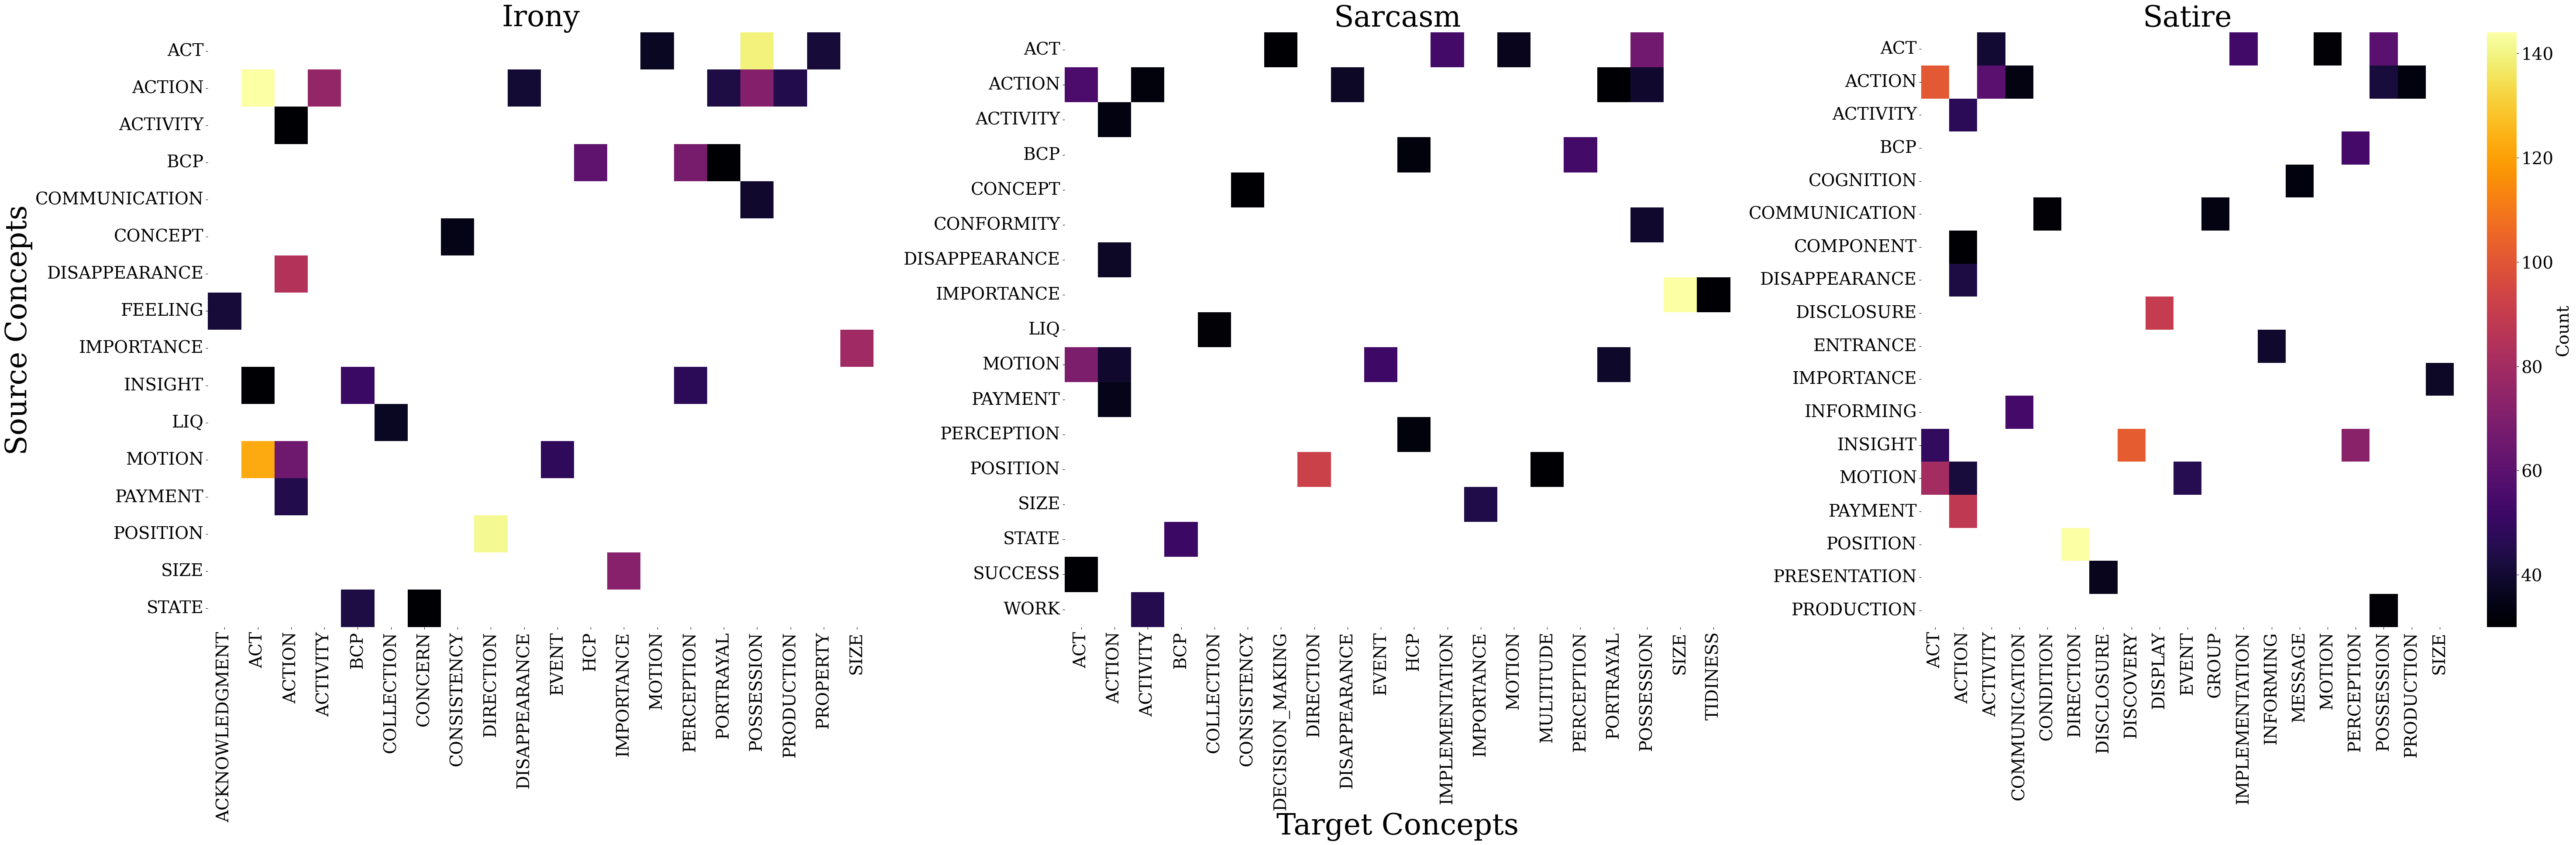

In [147]:
# Generate the combined subplots
fig, axes = plt.subplots(1, 3, figsize=(60, 20), sharey=False)

plot_heatmap(heatmap_data_irony, 'Irony', axes[0], cbar=False)
plot_heatmap(heatmap_data_sarcasm, 'Sarcasm', axes[1], cbar=False)
plot_heatmap(heatmap_data_satire, 'Satire', axes[2], cbar=True)

axes[0].set_xlabel('')
axes[2].set_xlabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')

# Set x and y labels for the left plot
axes[1].set_xlabel('Target Concepts', fontsize=48)
axes[0].set_ylabel('Source Concepts', fontsize=48)

plt.tight_layout()
plt.savefig('results/figures/combined_heatmap.png')
plt.show()

#### Relative Frequency Analysis

In [149]:
# Calculate relative frequency of the most common concept mappings
def calculate_relative_frequency(df, top_n=3000):
    concept_mapping_counts = df['Mapping'].value_counts().reset_index()
    concept_mapping_counts.columns = ['Mapping', 'Count']
    top_mappings = concept_mapping_counts.head(top_n)
    total_count = df['Mapping'].count()
    top_mappings.loc[:, 'Relative Frequency'] = top_mappings['Count'] / total_count
    return top_mappings

In [150]:
# Calculate relative frequencies for each dataset
irony_freq = calculate_relative_frequency(df_irony)
sarcasm_freq = calculate_relative_frequency(df_sarcasm)
satire_freq = calculate_relative_frequency(df_satire)

C:\Users\HP\AppData\Local\Temp\ipykernel_2208\1802456760.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_mappings.loc[:, 'Relative Frequency'] = top_mappings['Count'] / total_count
C:\Users\HP\AppData\Local\Temp\ipykernel_2208\1802456760.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_mappings.loc[:, 'Relative Frequency'] = top_mappings['Count'] / total_count
C:\Users\HP\AppData\Local\Temp\ipykernel_2208\1802456760.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [153]:
# Merge dataframes on 'Mapping'
merged_df = irony_freq.merge(sarcasm_freq, on='Mapping', how='outer', suffixes=('_Irony', '_Sarcasm'))
merged_df = merged_df.merge(satire_freq, on='Mapping', how='outer')
merged_df.columns = ['Mapping', 'Count_Irony', 'Rel_Freq_Irony', 'Count_Sarcasm', 'Rel_Freq_Sarcasm', 'Count_Satire', 'Rel_Freq_Satire']

# Replace NaNs with 0 for counts and relative frequencies
merged_df = merged_df.fillna(0)

# Filter to keep only mappings with high relative frequency in all three types
threshold = 0.00001  # Adjust the threshold as needed
common_mappings = merged_df[(merged_df['Rel_Freq_Irony'] >= threshold) &
                            (merged_df['Rel_Freq_Sarcasm'] >= threshold) &
                            (merged_df['Rel_Freq_Satire'] >= threshold)]

In [154]:
common_mappings['Total_Rel_Freq'] = common_mappings['Rel_Freq_Irony'] + common_mappings['Rel_Freq_Sarcasm'] + common_mappings['Rel_Freq_Satire']

# Sort by total relative frequency
common_mappings = common_mappings.sort_values(by='Total_Rel_Freq', ascending=False)

C:\Users\HP\AppData\Local\Temp\ipykernel_2208\3224667094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_mappings['Total_Rel_Freq'] = common_mappings['Rel_Freq_Irony'] + common_mappings['Rel_Freq_Sarcasm'] + common_mappings['Rel_Freq_Satire']


In [155]:
common_mappings = common_mappings.head(20)

In [156]:
# Update matplotlib settings for sans-serif font
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'serif',
})

In [157]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming irony_freq, sarcasm_freq, and satire_freq are your dataframes

# Merge dataframes on 'Mapping'
merged_df = irony_freq.merge(sarcasm_freq, on='Mapping', how='outer', suffixes=('_Irony', '_Sarcasm'))
merged_df = merged_df.merge(satire_freq, on='Mapping', how='outer')
merged_df.columns = ['Mapping', 'Count_Irony', 'Rel_Freq_Irony', 'Count_Sarcasm', 'Rel_Freq_Sarcasm', 'Count_Satire', 'Rel_Freq_Satire']

# Replace NaNs with 0 for counts and relative frequencies
merged_df = merged_df.fillna(0)

# Filter to keep only mappings with high relative frequency in all three types
threshold = 0.00001  # Adjust the threshold as needed
common_mappings = merged_df[(merged_df['Rel_Freq_Irony'] >= threshold) &
                            (merged_df['Rel_Freq_Sarcasm'] >= threshold) &
                            (merged_df['Rel_Freq_Satire'] >= threshold)]

# Add Total_Rel_Freq for sorting
common_mappings['Total_Rel_Freq'] = common_mappings['Rel_Freq_Irony'] + common_mappings['Rel_Freq_Sarcasm'] + common_mappings['Rel_Freq_Satire']

# Sort by total relative frequency
common_mappings = common_mappings.sort_values(by='Total_Rel_Freq', ascending=False)

# Filter dataframes to include only common mappings
filtered_irony = merged_df[merged_df['Mapping'].isin(common_mappings['Mapping'])]
filtered_sarcasm = merged_df[merged_df['Mapping'].isin(common_mappings['Mapping'])]
filtered_satire = merged_df[merged_df['Mapping'].isin(common_mappings['Mapping'])]

# Add Type column
filtered_irony['Type'] = 'Irony'
filtered_sarcasm['Type'] = 'Sarcasm'
filtered_satire['Type'] = 'Satire'

C:\Users\HP\AppData\Local\Temp\ipykernel_2208\3978177134.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_mappings['Total_Rel_Freq'] = common_mappings['Rel_Freq_Irony'] + common_mappings['Rel_Freq_Sarcasm'] + common_mappings['Rel_Freq_Satire']
C:\Users\HP\AppData\Local\Temp\ipykernel_2208\3978177134.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_irony['Type'] = 'Irony'
C:\Users\HP\AppData\Local\Temp\ipykernel_2208\3978177134.py:35: SettingWithCopyWarning: 
A value is trying to be s

#### Significance Test (for common concept mappings)

In [171]:
import scipy.stats as stats
# Function to calculate significance stars based on p-value
def significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''
    
# Function to compute significance stars for each mapping
def add_significance_stars(df, irony_col, sarcasm_col, satire_col):
    # Lists to store significance stars for each type
    star_irony = []
    star_sarcasm = []
    star_satire = []

    # Perform the chi-square test for each mapping
    for _, row in df.iterrows():
        observed = [row[irony_col], row[sarcasm_col], row[satire_col]]
        chi2, p_value = stats.chisquare(observed)
        
        # Assign the same p-value's significance stars to all three types
        star_irony.append(significance_stars(p_value))
        star_sarcasm.append(significance_stars(p_value))
        star_satire.append(significance_stars(p_value))

    # Add the significance stars to the DataFrame
    df['Star_Irony'] = star_irony
    df['Star_Sarcasm'] = star_sarcasm
    df['Star_Satire'] = star_satire

    return df

In [172]:
common_mappings_new = add_significance_stars(common_mappings, 'Count_Irony', 'Count_Sarcasm', 'Count_Satire')

In [183]:
# Filter rows with at least one significance star
significant_rows = common_mappings[
    (common_mappings['Star_Irony'] != '') |
    (common_mappings['Star_Sarcasm'] != '') |
    (common_mappings['Star_Satire'] != '')
]

# Sort by Total_Rel_Freq (or any other metric you prefer) and select the top 20 rows
top_20_significant_rows = significant_rows.sort_values(by='Total_Rel_Freq', ascending=False).head(20)
top_20_significant_rows.to_csv('results/tables/top_20_significant_mappings.csv', index=False)

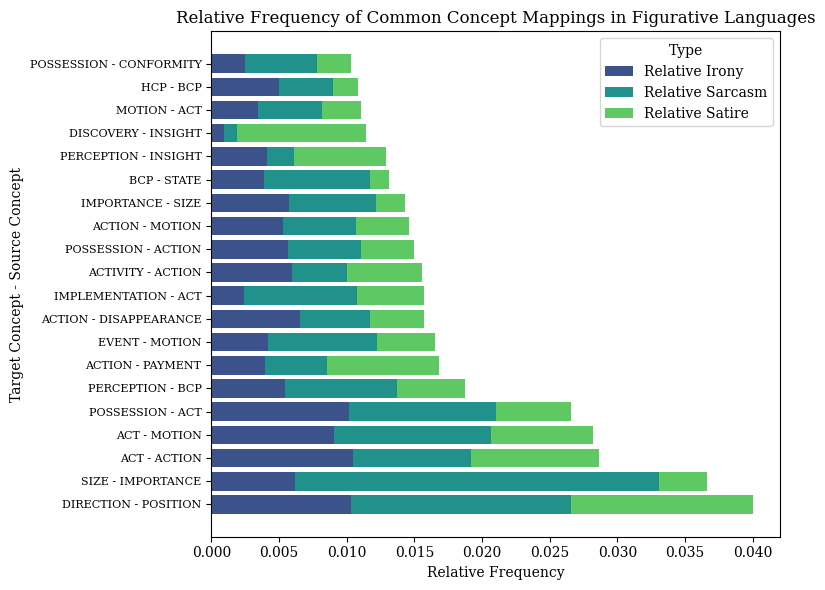

In [180]:
# Plotting
plt.figure(figsize=(8, 6))

# Set a different color palette
palette = sns.color_palette("viridis", 3)
# Define a custom soft, warm, and light color palette
# custom_palette = ['#FFB6C1', '#FFDAC9', '#FFFACD']  # LightPink, PeachPuff, LemonChiffon

# Plot the stacked bar plot
bottom_irony = top_20_significant_rows['Rel_Freq_Irony']
bottom_sarcasm = bottom_irony + top_20_significant_rows['Rel_Freq_Sarcasm']
# plt.barh(common_mappings['Mapping'], common_mappings['Rel_Freq_Irony'], color=custom_palette[0], label='Relative Irony')
# plt.barh(common_mappings['Mapping'], common_mappings['Rel_Freq_Sarcasm'], left=common_mappings['Rel_Freq_Irony'], color=custom_palette[1], label='Relative Sarcasm')
# plt.barh(common_mappings['Mapping'], common_mappings['Rel_Freq_Satire'], left=bottom_sarcasm, color=custom_palette[2], label='Relative Satire')


plt.barh(top_20_significant_rows['Mapping'][:20], top_20_significant_rows['Rel_Freq_Irony'][:20], color=palette[0], label='Relative Irony')
plt.barh(top_20_significant_rows['Mapping'][:20], top_20_significant_rows['Rel_Freq_Sarcasm'][:20], left=top_20_significant_rows['Rel_Freq_Irony'][:20], color=palette[1], label='Relative Sarcasm')
plt.barh(top_20_significant_rows['Mapping'][:20], top_20_significant_rows['Rel_Freq_Satire'][:20], left=bottom_sarcasm[:20], color=palette[2], label='Relative Satire')

plt.title('Relative Frequency of Common Concept Mappings in Figurative Languages')
plt.xlabel('Relative Frequency')
plt.ylabel('Target Concept - Source Concept')
plt.yticks(fontsize=8)
plt.legend(title='Type', loc='upper right')
plt.tight_layout()
plt.savefig('results/figures/relative_frequency_stacked_barplot_filtered.png')
plt.show()

### Distinct Concept Mappings

In [159]:
# Merge dataframes on 'Mapping'
merged_df = irony_freq.merge(sarcasm_freq, on='Mapping', how='outer', suffixes=('_Irony', '_Sarcasm'))
merged_df = merged_df.merge(satire_freq, on='Mapping', how='outer')
merged_df.columns = ['Mapping', 'Count_Irony', 'Rel_Freq_Irony', 'Count_Sarcasm', 'Rel_Freq_Sarcasm', 'Count_Satire', 'Rel_Freq_Satire']

# Replace NaNs with 0 for counts and relative frequencies
merged_df = merged_df.fillna(0)

In [160]:
merged_df.head()

,Mapping,Count_Irony,Rel_Freq_Irony,Count_Sarcasm,Rel_Freq_Sarcasm,Count_Satire,Rel_Freq_Satire
0,ABEYANCE - ACCIDENT,0.0,0.00000,3.0,0.000229,1.0,0.000094
1,ABILITY - ARTIFACT,0.0,0.00000,1.0,0.000076,0.0,0.000000
2,ABILITY - BCP,0.0,0.00000,1.0,0.000076,1.0,0.000094
3,ABILITY - MAGNITUDE,0.0,0.00000,1.0,0.000076,0.0,0.000000
4,ABILITY - VALUE,2.0,0.00015,0.0,0.000000,2.0,0.000187


In [161]:
# Calculate more extreme quantiles for filtering
high_irony = merged_df['Rel_Freq_Irony'].quantile(0.9)
high_sarcasm = merged_df['Rel_Freq_Sarcasm'].quantile(0.9)
high_satire = merged_df['Rel_Freq_Satire'].quantile(0.9)

low_irony = merged_df['Rel_Freq_Irony'].quantile(0.1)
low_sarcasm = merged_df['Rel_Freq_Sarcasm'].quantile(0.1)
low_satire = merged_df['Rel_Freq_Satire'].quantile(0.1)

# Filter mappings with high relative frequency in one type and low in others
distinct_irony = merged_df[(merged_df['Rel_Freq_Irony'] >= high_irony) &
                           (merged_df['Rel_Freq_Sarcasm'] <= low_sarcasm) &
                           (merged_df['Rel_Freq_Satire'] <= low_satire)]

distinct_sarcasm = merged_df[(merged_df['Rel_Freq_Sarcasm'] >= high_sarcasm) &
                             (merged_df['Rel_Freq_Irony'] <= low_irony) &
                             (merged_df['Rel_Freq_Satire'] <= low_satire)]

distinct_satire = merged_df[(merged_df['Rel_Freq_Satire'] >= high_satire) &
                            (merged_df['Rel_Freq_Irony'] <= low_irony) &
                            (merged_df['Rel_Freq_Sarcasm'] <= low_sarcasm)]

# Add Type column
distinct_irony['Type'] = 'Irony'
distinct_sarcasm['Type'] = 'Sarcasm'
distinct_satire['Type'] = 'Satire'

C:\Users\HP\AppData\Local\Temp\ipykernel_2208\3977629421.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distinct_irony['Type'] = 'Irony'
C:\Users\HP\AppData\Local\Temp\ipykernel_2208\3977629421.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distinct_sarcasm['Type'] = 'Sarcasm'
C:\Users\HP\AppData\Local\Temp\ipykernel_2208\3977629421.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

#### Significance Test (for distinct concept mappings)

In [162]:
import scipy.stats as stats

# Define a function to add significance stars based on p-value
def significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Apply Chi-Square Test on distinct mappings and add significance stars
def add_significance(df, irony_col, sarcasm_col, satire_col):
    p_values = []
    stars = []
    
    # For each row (concept mapping), perform the chi-square test
    for index, row in df.iterrows():
        # Extract the counts for the three categories
        observed = [row[irony_col], row[sarcasm_col], row[satire_col]]
        chi2, p_value = stats.chisquare(observed)        
        p_values.append(p_value)
        stars.append(significance_stars(p_value))
    
    # Add the results as new columns to the dataframe
    df['P_Value'] = p_values
    df['Significance'] = stars

    return df

In [163]:
# Apply the significance function to distinct irony, sarcasm, and satire mappings
distinct_irony = add_significance(distinct_irony, 'Count_Irony', 'Count_Sarcasm', 'Count_Satire')
distinct_sarcasm = add_significance(distinct_sarcasm, 'Count_Irony', 'Count_Sarcasm', 'Count_Satire')
distinct_satire = add_significance(distinct_satire, 'Count_Irony', 'Count_Sarcasm', 'Count_Satire')

C:\Users\HP\AppData\Local\Temp\ipykernel_2208\1934080953.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['P_Value'] = p_values
C:\Users\HP\AppData\Local\Temp\ipykernel_2208\1934080953.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Significance'] = stars
C:\Users\HP\AppData\Local\Temp\ipykernel_2208\1934080953.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

C:\Users\HP\AppData\Local\Temp\ipykernel_2208\3897151029.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)
C:\Users\HP\AppData\Local\Temp\ipykernel_2208\3897151029.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)
C:\Users\HP\AppData\Local\Temp\ipykernel_2208\3897151029.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


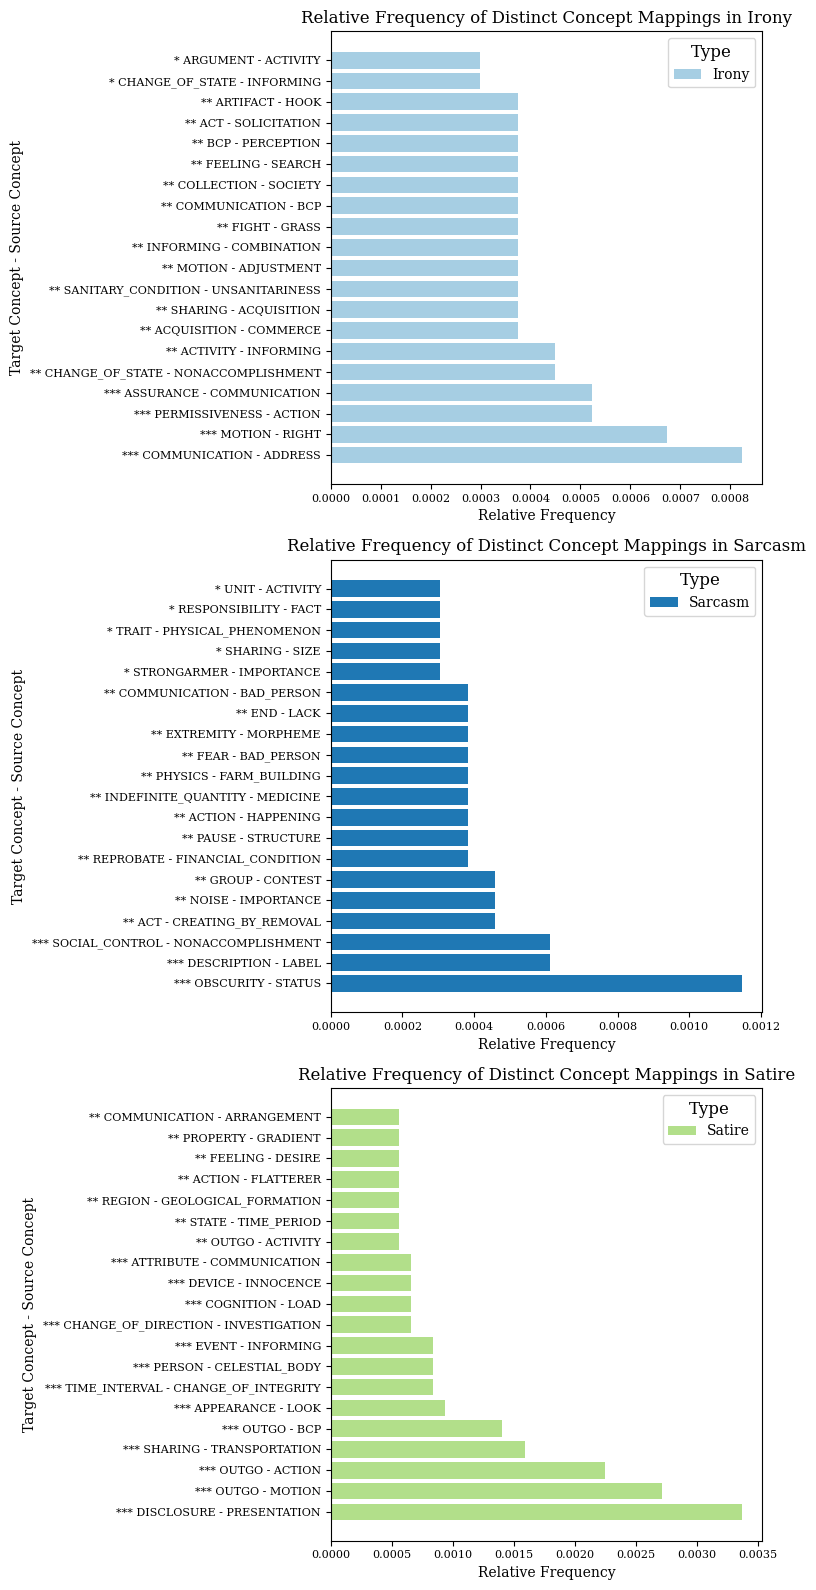

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns

# Adjusted plotting function to include significance stars next to y-axis labels
def plot_distinct_mappings(df, title, color, ax, freq_col):
    df = df.sort_values(by=freq_col, ascending=False).head(20)  # Select top 20 rows
    ax.barh(df['Mapping'], df[freq_col], color=color, label=title)
    
    # Add stars next to the y-axis labels (concept mappings)
    new_labels = [f"{mapping} {sig}" for mapping, sig in zip(df['Significance'], df['Mapping'])]
    ax.set_yticklabels(new_labels)
    
    ax.set_title(f'Relative Frequency of Distinct Concept Mappings in {title}')
    ax.set_xlabel('Relative Frequency')
    ax.set_ylabel('Target Concept - Source Concept')
    ax.legend(title='Type', loc='upper right', fontsize=10, title_fontsize=12)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Create subplots for irony, sarcasm, and satire
fig, axes = plt.subplots(3, 1, figsize=(8, 16))

# Set color palette
pastel_palette = sns.color_palette("Paired", 3)

# Plot distinct mappings for irony, sarcasm, and satire
plot_distinct_mappings(distinct_irony, 'Irony', pastel_palette[0], axes[0], 'Rel_Freq_Irony')
plot_distinct_mappings(distinct_sarcasm, 'Sarcasm', pastel_palette[1], axes[1], 'Rel_Freq_Sarcasm')
plot_distinct_mappings(distinct_satire, 'Satire', pastel_palette[2], axes[2], 'Rel_Freq_Satire')

# Adjust layout and save plot
plt.tight_layout()
plt.savefig('results/figures/distinct_mappings_with_significance_subplots_yaxis.png')
plt.show()


In [166]:
# Optionally, export to CSV for further analysis
distinct_irony.to_csv('results/tables/distinct_irony_with_significance.csv', index=False)
distinct_sarcasm.to_csv('results/tables/distinct_sarcasm_with_significance.csv', index=False)
distinct_satire.to_csv('results/tables/distinct_satire_with_significance.csv', index=False)

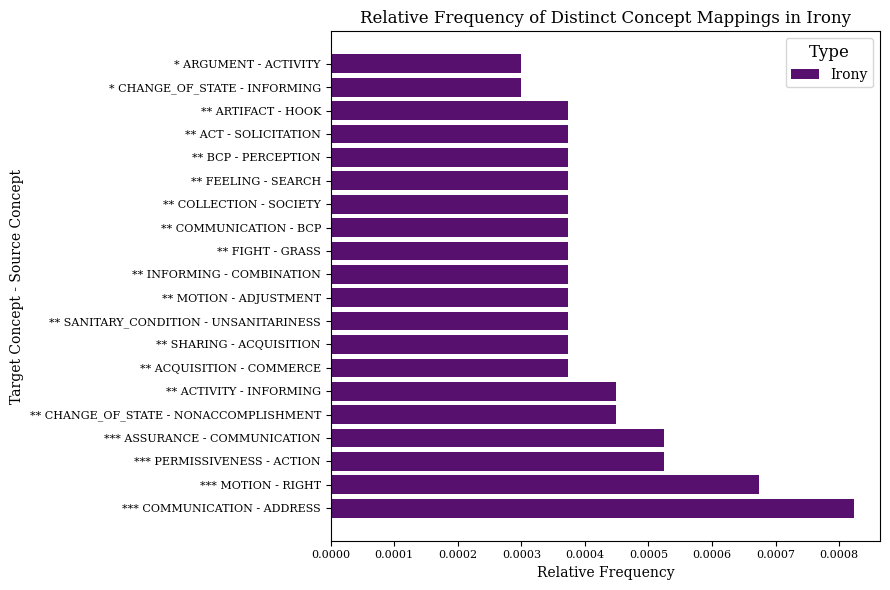

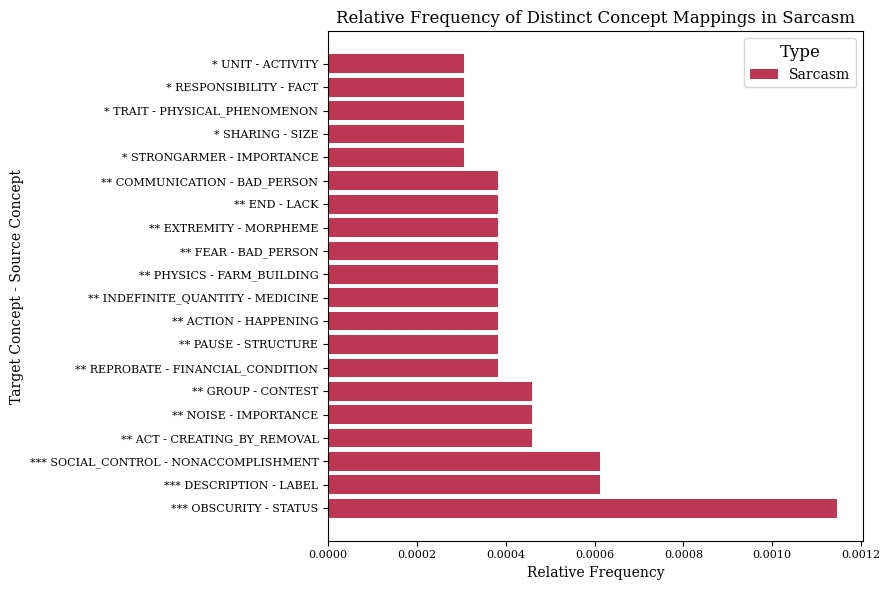

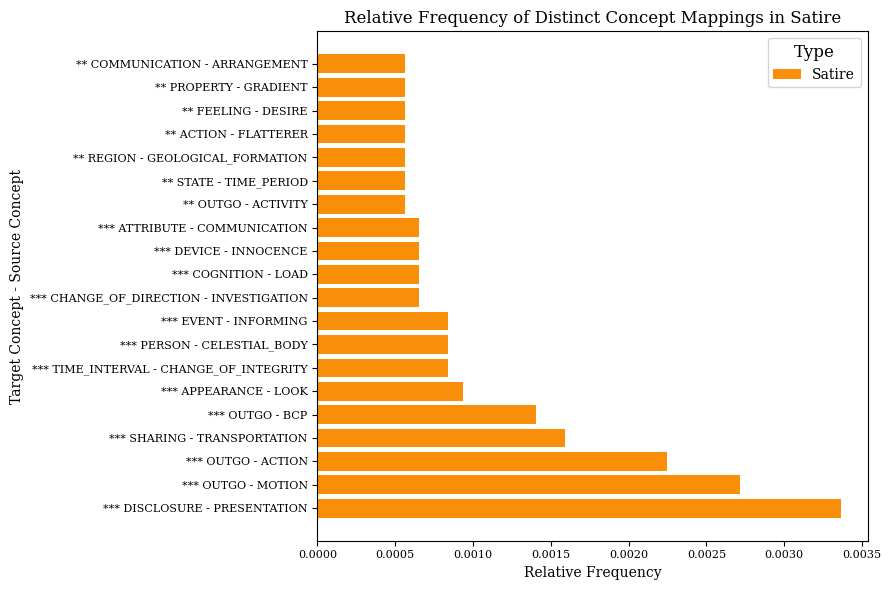

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

# Adjusted plotting function to include significance stars next to y-axis labels
def plot_distinct_mappings(df, title, color, freq_col, filename):
    plt.figure(figsize=(9, 6))  # Create a new figure for each plot
    df = df.sort_values(by=freq_col, ascending=False).head(20)  # Select top 20 rows
    plt.barh(df['Mapping'], df[freq_col], color=color, label=title)
    
    # Add stars next to the y-axis labels (concept mappings)
    new_labels = [f"{mapping} {sig}" for mapping, sig in zip(df['Significance'],df['Mapping'])]
    plt.yticks(range(len(new_labels)), new_labels)
    
    plt.title(f'Relative Frequency of Distinct Concept Mappings in {title}')
    plt.xlabel('Relative Frequency')
    plt.ylabel('Target Concept - Source Concept')
    plt.legend(title='Type', loc='upper right', fontsize=10, title_fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    plt.tight_layout()
    plt.savefig(f'results/figures/{filename}.png')  # Save each plot as a separate file
    plt.show()

# Set color palette
pastel_palette = sns.color_palette("inferno", 3)

# Plot distinct mappings for irony, sarcasm, and satire in separate plots
plot_distinct_mappings(distinct_irony, 'Irony', pastel_palette[0], 'Rel_Freq_Irony', 'distinct_mappings_irony')
plot_distinct_mappings(distinct_sarcasm, 'Sarcasm', pastel_palette[1], 'Rel_Freq_Sarcasm', 'distinct_mappings_sarcasm')
plot_distinct_mappings(distinct_satire, 'Satire', pastel_palette[2], 'Rel_Freq_Satire', 'distinct_mappings_satire')

In [135]:
# Function to find intersection of distinct mappings
def find_intersection(df1, df2, df3):
    # Find common mappings between all three dataframes
    common_mappings = pd.merge(df1[['Mapping']], df2[['Mapping']], on='Mapping', how='inner')
    common_mappings = pd.merge(common_mappings, df3[['Mapping']], on='Mapping', how='inner')
    return common_mappings

# Find common mappings across distinct irony, sarcasm, and satire
common_mappings = find_intersection(distinct_irony, distinct_sarcasm, distinct_satire)

In [137]:
common_mappings.head()
# Result verified

,Mapping


### Top 20 Mappings (verification)

In [169]:
def get_top_20_mappings(df, freq_col):
    return df.sort_values(by=freq_col, ascending=False).head(20)[['Mapping']]

# Get top 20 mappings from each distinct dataframe
top_20_irony = get_top_20_mappings(distinct_irony, 'Rel_Freq_Irony')
top_20_sarcasm = get_top_20_mappings(distinct_sarcasm, 'Rel_Freq_Sarcasm')
top_20_satire = get_top_20_mappings(distinct_satire, 'Rel_Freq_Satire')

# Add a column to indicate the category
top_20_irony['Irony'] = top_20_irony['Mapping']
top_20_sarcasm['Sarcasm'] = top_20_sarcasm['Mapping']
top_20_satire['Satire'] = top_20_satire['Mapping']

# Merge the top 20 dataframes into one
merged_top_20 = pd.merge(top_20_irony, top_20_sarcasm, on='Mapping', how='outer')
merged_top_20 = pd.merge(merged_top_20, top_20_satire, on='Mapping', how='outer')

# Fill NaNs with empty strings
merged_top_20 = merged_top_20.fillna('')

# Rearrange columns to have 'Mapping', 'Irony', 'Sarcasm', 'Satire'
merged_top_20 = merged_top_20[['Mapping', 'Irony', 'Sarcasm', 'Satire']]
merged_top_20.to_csv('merged_top_20_distinct_mappings.csv', index=False)

In [170]:
print("Irony Mapping")
for mapping in merged_top_20['Irony']:
    if mapping != '':
        print(mapping)
        break

print("Sarcasm Mapping")
for mapping in merged_top_20['Sarcasm']:
    if mapping != '':
        print(mapping)
        break

print("Satire Mapping")
for mapping in merged_top_20['Satire']:
    if mapping != '':
        print(mapping)
        break

Irony Mapping
ACQUISITION - COMMERCE
Sarcasm Mapping
ACT - CREATING_BY_REMOVAL
Satire Mapping
ACTION - FLATTERER


### Finding irony examples

In [143]:
def find_example():
    pattern = re.compile('UNPLEASANT_PERSON')
    for data in irony_data:
        for key in data:
            metapro_output = data[key]['metapro_output']
            if pattern.search(metapro_output):
                print(data[key]['headline'])
                return
find_example()

marcorubio is bitching about new cubausa diplomatic relations writing speeches against it in the computer made in communist china irony


Code Credits: Liza Dahiya | lizadahiya23@gmail.com